In [1]:
import tensorflow as tf
from utils import custom_loss
from PIL import Image
import numpy as np
from utils import process_predictions

2022-09-30 13:05:24.539240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 13:05:26.891569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 13:05:26.891625: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-30 13:05:27.138934: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 13:05:30.948164: W tensorflow/stream_executor/platform/de

In [2]:
model = tf.keras.models.load_model('model', custom_objects = {"custom_loss": custom_loss})

2022-09-30 13:05:37.515298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-30 13:05:37.515332: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-30 13:05:37.515363: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rajarshi-EEE): /proc/driver/nvidia/version does not exist
2022-09-30 13:05:37.515515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [133]:
import requests

In [174]:
url = "https://s.yimg.com/ny/api/res/1.2/HSbU2Ghk99gMXFpT6Zaevw--/YXBwaWQ9aGlnaGxhbmRlcjt3PTk2MDtoPTEzMTM7Y2Y9d2VicA--/https://s.yimg.com/uu/api/res/1.2/EdS5a2GEnqRNarr8p9U6yA--~B/aD0yMDAwO3c9MTQ2MjthcHBpZD15dGFjaHlvbg--/https://media.zenfs.com/en/southern_living_806/2f6cc6d0954e015e0fe2046a4f0c37f2"
r = requests.get(url, allow_redirects=True)

In [175]:
open('image.jpg', 'wb').write(r.content)

539438

In [191]:
image = Image.open("./train/0a3cb453f.jpg")
image = image.resize((256,256))

In [192]:
import albumentations as albu

In [9]:
preprocess = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

In [193]:
image = np.array(image)
image = preprocess(image = image)
image = image['image']/255

In [141]:
image.shape

(256, 256, 3)

In [194]:
image = np.expand_dims(image, axis = 0)

In [179]:
image.shape

(1, 256, 256, 3)

In [14]:
from PIL import ImageDraw

In [195]:
pred = model.predict(image)

1/1 [==============================] - 0s 33ms/step


In [144]:
pred.shape

(1, 32, 32, 10)

In [56]:
def form_image_grid():    
    image_grid = np.zeros((32, 32, 4))

    # x, y, width, height
    cell = [0, 0, 256 / 32, 256 / 32] 

    for i in range(0, 32):
        for j in range(0, 32):
            image_grid[i,j] = cell

            cell[0] = cell[0] + cell[2]

        cell[0] = 0
        cell[1] = cell[1] + cell[3]

    return image_grid

In [13]:
form_image_grid().shape

(32, 32, 4)

In [196]:
pred = np.squeeze(pred)

In [170]:
pred.shape

(32, 32, 10)

In [197]:
pred = process_predictions(pred, form_image_grid())

(32, 32, 10)
(60, 4)


In [37]:
pred

array([], shape=(0, 4), dtype=float32)

In [189]:
from matplotlib.pyplot import imshow

In [38]:
def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open(image_id)
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')

In [200]:
drawn = draw_bboxes("./train/0a3cb453f.jpg", bboxes = pred)

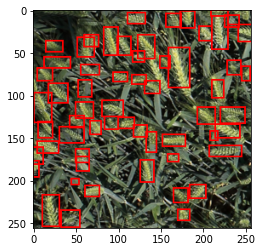

In [201]:
imshow(drawn)